In [128]:
import os
import sys
import yaml
import copy
import warnings
import importlib as imp
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import pcl
import pyntcloud

sys.path.append('/home/jovyan/work/obstacle-detection/')

In [118]:
with open('../config.yaml') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

In [139]:
# Segments id -> name mapping
seg_lst = config['segments']
# seg_lst

In [125]:
# Obstacles id -> name mapping
obstacle_lst = config['obstacles']
obstacle_lst

{10: 'car',
 11: 'bicycle',
 13: 'bus',
 15: 'motorcycle',
 16: 'on-rails',
 18: 'truck',
 20: 'other-vehicle',
 30: 'person',
 31: 'bicyclist',
 32: 'motorcyclist',
 252: 'moving-car',
 253: 'moving-bicyclist',
 254: 'moving-person',
 255: 'moving-motorcyclist',
 256: 'moving-on-rails',
 257: 'moving-bus',
 258: 'moving-truck',
 259: 'moving-other-vehicle'}

In [136]:
num ='066'
scan = np.fromfile('../dataset/sequences/00/velodyne/000' + num + '.bin', dtype=np.float32)
scan = scan.reshape((-1, 4))

label = np.fromfile('../dataset/sequences/00/labels/000' + num + '.label', dtype=np.uint32)
label = label.reshape((-1))

In [147]:
label = [seg & 0xFFFF for seg in label]
unq = list(set(label))
print('Scan have:')
for seg in unq:
    if seg in list(seg_lst.keys()):
        print(seg, seg_lst[seg])

Scan have:
0 unlabeled
1 outlier
99 other-object
70 vegetation
71 trunk
40 road
72 terrain
10 car
11 bicycle
44 parking
80 pole
81 traffic-sign
50 building
51 fence
48 sidewalk
20 other-vehicle
60 lane-marking
253 moving-bicyclist


In [165]:
# pcloud = pyntcloud.PyntCloud(pcloud)

In [261]:
# pcloud = pd.DataFrame(scan, columns=['x', 'y', 'z'])
# test_cloud.plot(use_as_color='seg_id', cmap="cool")

In [166]:
# pcloud.plot(use_as_color='camera', cmap="cool")

In [294]:
# is_parking = ~test_cloud.points['seg_id'].isin(list(obstacle_lst.keys()))
# test_cloud.points['is_parking'] = pd.Series(is_parking)

In [167]:
# test_cloud.plot(use_as_color='is_parking', cmap="RdYlGn", output_name="is_parking")

In [168]:
# is_parking = test_cloud.points['is_parking'] != 1
# test_cloud.apply_filter(is_parking)

In [169]:
# test_cloud.plot()

In [90]:
# n_voxels = 45
# voxelgrid_id = test_cloud.add_structure("voxelgrid", n_x=n_voxels, n_y=n_voxels, n_z=10)

In [170]:
# %time cluster_id = test_cloud.add_scalar_field("euclidean_clusters",voxelgrid_id=voxelgrid_id)

In [171]:
# test_cloud.plot(use_as_color=cluster_id, cmap="cool")

In [888]:
from pipeline import common
common = imp.reload(common)

In [951]:
def pipeline_optimized(scan, label, obstacle_lst, verbose=False, exec_time=False, **params):
    
    # ROI filter 
    start_time = datetime.now()
    pcloud = pd.DataFrame(np.concatenate((scan, label.reshape(len(label), 1)), axis=1), 
                                                    columns=['x', 'y', 'z', 'seg_id'])
    
    pcloud = common.roi_filter(pcloud,  min_x=params['roi_x_min'], max_x=params['roi_x_max'], 
                                        min_y=params['roi_y_min'],max_y=params['roi_y_max'],
                                        min_z=params['roi_z_min'], max_z=params['roi_z_max'], verbose=False)
    roi_time = datetime.now() - start_time
    
    # get segment id
    start_time = datetime.now()
    pcloud = common.obstacle_filter(pcloud, obstacle_lst, proc_labels=True, verbose=False)
    pcloud = pyntcloud.PyntCloud(pcloud)
    obstacle_time = datetime.now() - start_time
    
    
    # get voxel grid
    start_time = datetime.now()
    voxelgrid_id = pcloud.add_structure("voxelgrid", n_x=params['x_voxels'], 
                                                     n_y=params['y_voxels'],
                                                     n_z=params['z_voxels'])
    voxel_time = datetime.now() - start_time
    
    
    # get cluster
    start_time = datetime.now()
    cluster_id = pcloud.add_scalar_field("euclidean_clusters", voxelgrid_id=voxelgrid_id)
    cluster_time = datetime.now() - start_time

    
    # get cluster min max
    start_time = datetime.now()
    clusters = []
    pcloud.points['norm'] = np.sqrt(np.square(pcloud.points[['x', 'y', 'z']]).sum(axis=1))
    for _id in pcloud.points[cluster_id].unique():
        tcluster = common.outlier_filter(pcloud.points[pcloud.points[cluster_id] == _id])
        min_max = tcluster.groupby(['seg_id']).agg({   'x': ['min', 'max'],
                                                       'y': ['min', 'max'],
                                                       'z': ['min', 'max'] })
        clusters.append(min_max.values)
    min_max_time = datetime.now() - start_time
    
    
    cluster_data = pcloud.points[['x', 'y', 'z', cluster_id]].rename(columns ={cluster_id: 'cluster_id'})
    
    n = 1000
    if verbose:
        print('Execution time:')
        print('\n - ROI filtering: {:.0f} ms'.format(roi_time.microseconds / n))
        print('\n - Filtering obstacles: {:.0f} ms'.format(obstacle_time.microseconds / n))
        print('\n - Voxel grid: {:.0f} ms'.format(voxel_time.microseconds / n))
        print('\n - Clustering: {:.0f} ms'.format(cluster_time.microseconds / n))
        print('\n - Min-max cluster points: {:.0f} ms \n'.format(min_max_time.microseconds / n))
        
    if exec_time:
        return clusters, cluster_data, {'roi_time': roi_time.microseconds / n,
                                        'filter_obstacle_time': obstacle_time.microseconds / n,
                                        'voxel_grid_time': voxel_time.microseconds / n,
                                        'clustering_time': cluster_time.microseconds / n,
                                        'outlier_filter_bbox_time': min_max_time.microseconds / n}
    else:
        return clusters, cluster_data

## Pipeline implementation

In [1004]:
%time 
num='090'
scan = np.fromfile('../dataset/sequences/00/velodyne/000' + num + '.bin', dtype=np.float32)
scan = scan.reshape((-1, 4))[:,:3]

label = np.fromfile('../dataset/sequences/00/labels/000' + num + '.label', dtype=np.uint32)
label = label.reshape((-1))

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 17.4 µs


In [1006]:
%%time
params = {'x_voxels': 25, 'y_voxels': 25, 'z_voxels': 7, 
          'roi_x_min': 0, 'roi_x_max': 45,
          'roi_y_min': -15, 'roi_y_max': 15,
          'roi_z_min': -2, 'roi_z_max': 1}
          
clusters, cluster_data = pipeline_optimized(scan, label, obstacle_lst, verbose=True, 
                                            **params)

Execution time:

 - ROI filtering: 20 ms

 - Filtering obstacles: 102 ms

 - Voxel grid: 2 ms

 - Clustering: 448 ms

 - Min-max cluster points: 475 ms 

CPU times: user 1.05 s, sys: 671 µs, total: 1.05 s
Wall time: 1.05 s


In [971]:
%%timeit
clusters, cluster_data = pipeline_optimized(scan, label, obstacle_lst, verbose=False, **params)

1.02 s ± 18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [956]:
records = []
for x in clusters:
    for y in x:
        records.append(y)

In [957]:
rec = pd.DataFrame.from_records(records)

In [958]:
%time box_coord_list = get_bounding_boxes(rec)
print('It is {} clusters'.format(len(box_coord_list)))

CPU times: user 3.04 ms, sys: 2.83 ms, total: 5.86 ms
Wall time: 7.82 ms
It is 14 clusters


In [959]:
# %time box_coord_list = common.get_optimal_bboxes(clusters, cluster_data)
# print(len(box_coord_list))

In [960]:
test_cloud = pyntcloud.PyntCloud(cluster_data)
test_cloud.plot(use_as_color='cluster_id', cmap="cool")

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(5.97601919505665, 18.789988803327578, -0.936…

In [262]:
# cluster_data

In [917]:
from scripts import draw
draw = imp.reload(draw)

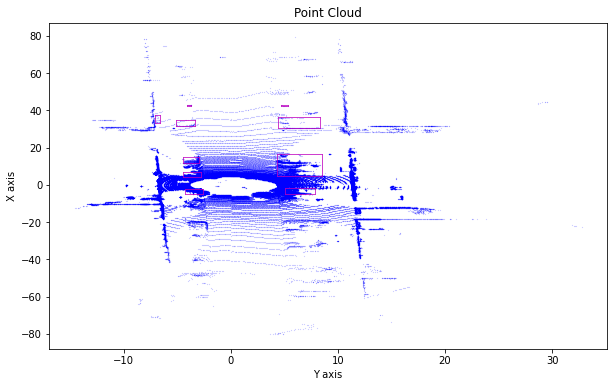

In [918]:
%matplotlib inline
f = plt.figure(figsize=(10, 6))
axes = [1,0]
# ax = f.add_subplot(111, projection='3d') 
ax = f.add_subplot(111) 
draw.draw_point_cloud(scan, ax, 'Point Cloud',axes=axes, 
                      axes_str = ['X', 'Y', 'Z'], )
for box in box_coord_list:
     draw.draw_box(ax, box, axes=axes, color='m')

In [919]:
pcloud = pd.DataFrame(np.concatenate((scan, label.reshape(len(label), 1)), axis=1), 
                                                    columns=['x', 'y', 'z', 'seg_id'])
%time cloud = common.obstacle_filter(pcloud, obstacle_lst)

Filter required segments
Point size before: 120793 and after filtering: 16053
CPU times: user 171 ms, sys: 0 ns, total: 171 ms
Wall time: 173 ms


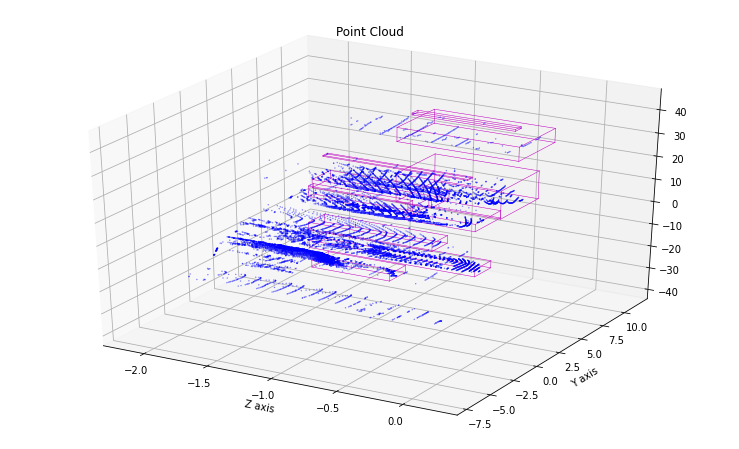

In [920]:
%matplotlib inline
spoints = cloud[['x','y','z']]
f = plt.figure(figsize=(13, 8))
axes = [2,1,0]
ax = f.add_subplot(111, projection='3d') 
draw.draw_point_cloud(spoints.values, ax, 'Point Cloud',axes=axes, axes_str=['X', 'Y', 'Z'])
for box in box_coord_list:
     draw.draw_box(ax, box, axes=axes, color='m')

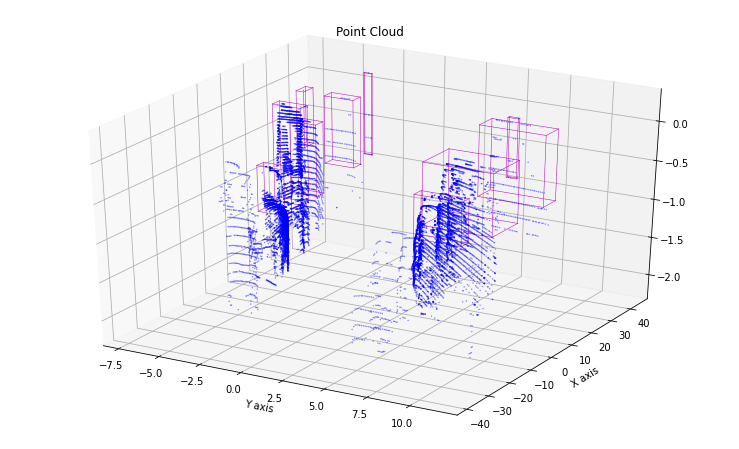

In [921]:
%matplotlib inline
spoints = cloud[['x','y','z']]
f = plt.figure(figsize=(13, 8))
axes = [1,0,2]
ax = f.add_subplot(111, projection='3d') 
draw.draw_point_cloud(spoints.values, ax, 'Point Cloud',axes=axes, axes_str=['X', 'Y', 'Z'])
for box in box_coord_list:
     draw.draw_box(ax, box, axes=axes, color='m')

## Grid Search Optimization

In [1022]:
from scripts import test
test = imp.reload(test)
range_params = params = { 'x_voxels': [22, 23, 25 ,30], 'y_voxels': [22, 23, 25 ,30], 
                          'z_voxels': [2, 3, 5, 6, 7, 8, 10], 
                          'roi_x_min': [0], 'roi_x_max': [45],
                          'roi_y_min': [-15], 'roi_y_max': [15],
                          'roi_z_min': [-2], 'roi_z_max': [1]}
time_exec_lst = test.grid_search_optimization(scan, label, obstacle_lst, pipeline_optimized, range_params)

Total time 969.5819999999999 ms. Created 10 clusters
****************************************
{
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "x_voxels": 22,
   "y_voxels": 22,
   "z_voxels": 2
}
{
   "roi_time": 17.129,
   "filter_obstacle_time": 111.826,
   "voxel_grid_time": 2.267,
   "clustering_time": 437.376,
   "outlier_filter_bbox_time": 400.984
}
****************************************

Total time 882.961 ms. Created 10 clusters
****************************************
{
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "x_voxels": 22,
   "y_voxels": 22,
   "z_voxels": 3
}
{
   "roi_time": 19.643,
   "filter_obstacle_time": 125.519,
   "voxel_grid_time": 1.738,
   "clustering_time": 337.639,
   "outlier_filter_bbox_time": 398.422
}
****************************************

Total time 863.671 ms. Created 10 clusters
***************

Total time 972.5 ms. Created 11 clusters
****************************************
{
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "x_voxels": 22,
   "y_voxels": 25,
   "z_voxels": 7
}
{
   "roi_time": 23.373,
   "filter_obstacle_time": 122.863,
   "voxel_grid_time": 0.925,
   "clustering_time": 388.647,
   "outlier_filter_bbox_time": 436.692
}
****************************************

Total time 1258.528 ms. Created 11 clusters
****************************************
{
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "x_voxels": 22,
   "y_voxels": 25,
   "z_voxels": 8
}
{
   "roi_time": 23.811,
   "filter_obstacle_time": 124.245,
   "voxel_grid_time": 2.136,
   "clustering_time": 686.12,
   "outlier_filter_bbox_time": 422.216
}
****************************************

Total time 1280.578 ms. Created 11 clusters
**************************

Total time 859.865 ms. Created 10 clusters
****************************************
{
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "x_voxels": 23,
   "y_voxels": 23,
   "z_voxels": 3
}
{
   "roi_time": 23.532,
   "filter_obstacle_time": 112.281,
   "voxel_grid_time": 2.016,
   "clustering_time": 355.12,
   "outlier_filter_bbox_time": 366.916
}
****************************************

Total time 895.173 ms. Created 10 clusters
****************************************
{
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "x_voxels": 23,
   "y_voxels": 23,
   "z_voxels": 5
}
{
   "roi_time": 21.611,
   "filter_obstacle_time": 116.56,
   "voxel_grid_time": 2.287,
   "clustering_time": 361.87,
   "outlier_filter_bbox_time": 392.845
}
****************************************

Total time 1225.147 ms. Created 10 clusters
***************************

Total time 1236.339 ms. Created 10 clusters
****************************************
{
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "x_voxels": 23,
   "y_voxels": 30,
   "z_voxels": 8
}
{
   "roi_time": 23.68,
   "filter_obstacle_time": 121.205,
   "voxel_grid_time": 2.355,
   "clustering_time": 698.078,
   "outlier_filter_bbox_time": 391.021
}
****************************************

Total time 1270.766 ms. Created 10 clusters
****************************************
{
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "x_voxels": 23,
   "y_voxels": 30,
   "z_voxels": 10
}
{
   "roi_time": 22.571,
   "filter_obstacle_time": 123.949,
   "voxel_grid_time": 2.388,
   "clustering_time": 731.976,
   "outlier_filter_bbox_time": 389.882
}
****************************************

Total time 1053.877 ms. Created 11 clusters
**********************

Total time 1065.926 ms. Created 12 clusters
****************************************
{
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "x_voxels": 25,
   "y_voxels": 25,
   "z_voxels": 5
}
{
   "roi_time": 23.6,
   "filter_obstacle_time": 126.201,
   "voxel_grid_time": 2.295,
   "clustering_time": 449.448,
   "outlier_filter_bbox_time": 464.382
}
****************************************

Total time 1489.2069999999999 ms. Created 12 clusters
****************************************
{
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "x_voxels": 25,
   "y_voxels": 25,
   "z_voxels": 6
}
{
   "roi_time": 23.813,
   "filter_obstacle_time": 120.998,
   "voxel_grid_time": 2.279,
   "clustering_time": 806.236,
   "outlier_filter_bbox_time": 535.881
}
****************************************

Total time 1067.053 ms. Created 12 clusters
**************

Total time 1344.022 ms. Created 11 clusters
****************************************
{
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "x_voxels": 30,
   "y_voxels": 22,
   "z_voxels": 10
}
{
   "roi_time": 19.361,
   "filter_obstacle_time": 104.569,
   "voxel_grid_time": 2.023,
   "clustering_time": 793.705,
   "outlier_filter_bbox_time": 424.364
}
****************************************

Total time 1109.015 ms. Created 11 clusters
****************************************
{
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "x_voxels": 30,
   "y_voxels": 23,
   "z_voxels": 2
}
{
   "roi_time": 26.205,
   "filter_obstacle_time": 136.305,
   "voxel_grid_time": 2.28,
   "clustering_time": 494.714,
   "outlier_filter_bbox_time": 449.511
}
****************************************

Total time 1012.323 ms. Created 11 clusters
**********************

Total time 1362.572 ms. Created 11 clusters
****************************************
{
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "x_voxels": 30,
   "y_voxels": 30,
   "z_voxels": 6
}
{
   "roi_time": 22.85,
   "filter_obstacle_time": 112.523,
   "voxel_grid_time": 2.344,
   "clustering_time": 812.501,
   "outlier_filter_bbox_time": 412.354
}
****************************************

Total time 1057.7160000000001 ms. Created 11 clusters
****************************************
{
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "x_voxels": 30,
   "y_voxels": 30,
   "z_voxels": 7
}
{
   "roi_time": 22.376,
   "filter_obstacle_time": 118.299,
   "voxel_grid_time": 2.12,
   "clustering_time": 494.144,
   "outlier_filter_bbox_time": 420.777
}
****************************************

Total time 1430.201 ms. Created 11 clusters
**************

In [1025]:
for key in time_exec_lst:
    print(key,'Time and n clusters', time_exec_lst[key])

{
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "x_voxels": 22,
   "y_voxels": 22,
   "z_voxels": 2
} Time and n clusters (969.5819999999999, 10)
{
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "x_voxels": 22,
   "y_voxels": 22,
   "z_voxels": 3
} Time and n clusters (882.961, 10)
{
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "x_voxels": 22,
   "y_voxels": 22,
   "z_voxels": 5
} Time and n clusters (863.671, 10)
{
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "x_voxels": 22,
   "y_voxels": 22,
   "z_voxels": 6
} Time and n clusters (1154.702, 10)
{
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "x_voxels": 22,
 

## Getting bounding boxes for sequence 00

In [922]:
import glob
scan_lst = sorted(glob.glob("../dataset/sequences/00/velodyne/*.bin"))
labels_lst = sorted(glob.glob("../dataset/sequences/00/labels/*.label"))
assert len(scan_lst) == len(labels_lst)
print('READ OK, number of scans ', len(scan_lst))

READ OK, number of scans  459


In [923]:
from scripts import test
test = imp.reload(test)

In [924]:
# help(test.get_bbox_and_stat)

In [926]:
%%time
n_scan = -1
# write_path = '../dataset/sequences/00/velodyne/000355.bin'
bbox_dct, exec_time_dct, stats = test.get_bbox_and_stat(scan_lst[:n_scan], labels_lst[:n_scan], obstacle_lst,
                                                 pipeline_optimized, 
                                                 write_path=None, detailed=True, **params)


CPU times: user 4min 16s, sys: 4.85 s, total: 4min 21s
Wall time: 4min 53s


In [927]:
steps = list(stats[0].keys())
steps_exec_time = []
for step in steps:
    steps_exec_time.append([stat[step] for stat in stats])

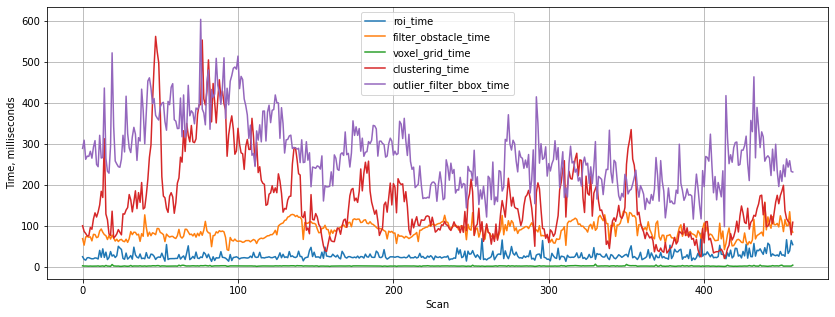

In [928]:
plt.figure(figsize=(14,5))
for i, step in enumerate(steps):
    plt.plot(steps_exec_time[i], label=step)
plt.legend(loc='best')
plt.xlabel('Scan')
plt.ylabel('Time, milliseconds')
plt.grid()
plt.show()

In [929]:
time_stat = list(exec_time_dct.values())
print('Min process time {} ms'.format(min(time_stat)))
print('Mean process time {} ms'.format(np.mean(time_stat)))
print('Max process time {} ms'.format(max(time_stat)))

Min process time 11.015 ms
Mean process time 539.9834868995633 ms
Max process time 997.324 ms


In [930]:
ox = [int(x) for x in list(exec_time_dct.keys())]
oy = time_stat

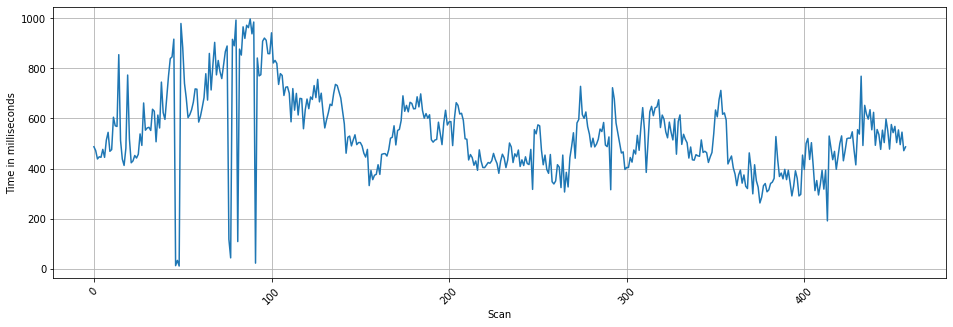

In [931]:
plt.figure(figsize=(16, 5))
plt.plot(ox, oy)
plt.xlabel('Scan')
plt.ylabel('Time in milliseconds')
plt.grid()
plt.xticks(rotation=45)
plt.show()

### Grep statistics of execution time

In [442]:
exec_lst = []
n_epoch = 3
for i in range(n_epoch):
    _, exec_time_dct = test.get_bbox_and_stat(scan_lst, labels_lst, obstacle_lst,
                                              pipeline_optimized, write_path=None,
                                                                  x_voxels=25,
                                                                  y_voxels=20,
                                                                  z_voxels=5)
    exec_lst.append(exec_time_dct)

In [452]:
several_exec_time_lst = [] 
for epoch in exec_lst:
    several_exec_time_lst.append([tdelta.microseconds for tdelta in epoch.values()])
several_exec_time_lst = list(zip(several_exec_time_lst[0],
                                 several_exec_time_lst[1],
                                 several_exec_time_lst[2]))

In [454]:
several_exec_time_lst[:3]

[(387403, 382174, 361611), (418736, 408954, 395278), (383912, 373594, 357415)]

In [457]:
oy_mean = [np.mean(exec_times) for exec_times in several_exec_time_lst]
oy_min = [min(exec_times) for exec_times in several_exec_time_lst]
oy_max = [max(exec_times) for exec_times in several_exec_time_lst]

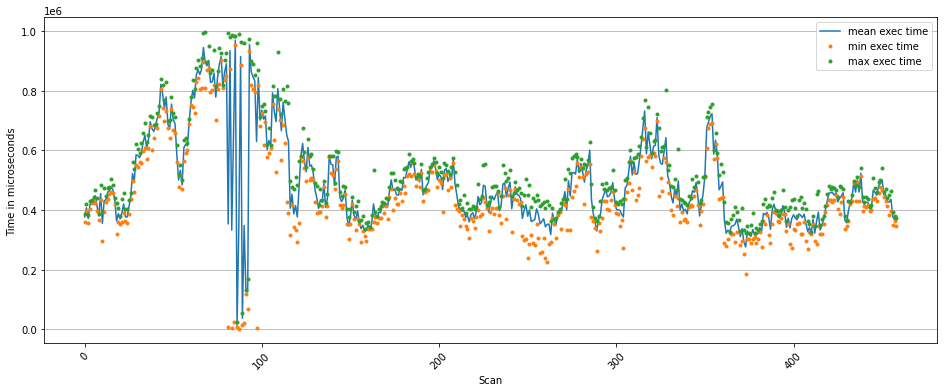

In [464]:
plt.figure(figsize=(16, 6))
plt.plot(ox, oy_mean, label='mean exec time')
plt.plot(ox, oy_min, '.', label='min exec time')
plt.plot(ox, oy_max, '.', label='max exec time')
ax = plt.axes()        
ax.yaxis.grid()
plt.xticks(rotation=45)
plt.xlabel('Scan')
plt.ylabel('Time in microseconds')
plt.legend()
plt.show()